In [1]:
import numpy as np
from scipy import stats 
import pandas as pd
from tqdm import tqdm_notebook
import cdpm
import pandas_datareader as pd_reader
from sklearn.preprocessing import add_dummy_feature
import matplotlib as mpl
import random

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
num_draws = int(5e3)
include_mean = True
mode = '.tmp'
# mode = ''

In [4]:
time_dim = 300;

# consider two mixtures

Phi1_1 = np.array([[0.7, -0.2],[0.0, 0.9]])
Phi0_1 = np.array([0.2,0.1])
Sigma_1 = np.array([[0.3,0.0],[0.2,0.3]])

Phi1_2 = np.array([[0.6, 0.0],[0.1, 0.5]])
Phi0_2 = np.array([0.0,-0.15])
Sigma_2 = np.array([[0.25,0.0],[-0.1,0.35]])


state_dim = Phi1_1.shape[1]
#ydata_n = np.empty((time_dim, state_dim))
simdata = np.empty((time_dim, state_dim))

In [5]:
Sigma_1.dot(Sigma_1)

array([[0.09, 0.  ],
       [0.12, 0.09]])

In [6]:
Sigma_2.dot(Sigma_2)

array([[ 0.0625,  0.    ],
       [-0.06  ,  0.1225]])

In [7]:
mixture_prob = np.random.uniform(0,1,time_dim) # mixture probability


In [8]:
random.seed(123)

# with normal distributed shock
for t in range(1, time_dim):
    error = stats.multivariate_normal.rvs(cov=np.identity(state_dim))
    simdata[t, :] = mixture_prob[t-1]*(Phi0_1 + Phi1_1.dot(simdata[t-1,:]-Phi0_1) + Sigma_1.dot(error))
+(1-mixture_prob[t-1])*(Phi0_2 + Phi1_2.dot(simdata[t-1,:]-Phi0_2) + Sigma_2.dot(error))

array([-0.11021824,  0.32385714])

In [9]:
data = pd.DataFrame(simdata)
data.index = pd.date_range(start='1995', freq='W', periods=time_dim)
data = data.transform(stats.zscore).dropna() # standardize

In [10]:
mixture_prob = pd.DataFrame(mixture_prob)

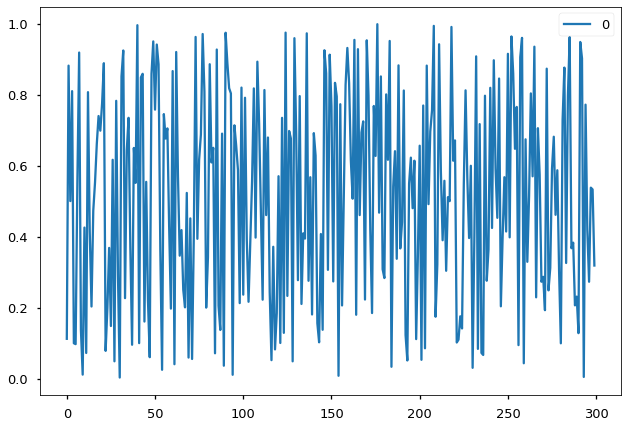

In [11]:
mixture_prob.plot()

In [12]:
data.columns = ['Var1', 'Var2']

In [13]:
data.describe()

Var1        Var2
count  3.000000e+02  300.000000
mean   5.033011e-17    0.000000
std    1.001671e+00    1.001671
min   -3.001292e+00   -5.508086
25%   -5.209285e-01   -0.434453
50%   -1.650665e-01    0.048653
75%    4.728139e-01    0.460960
max    3.444649e+00    2.987520

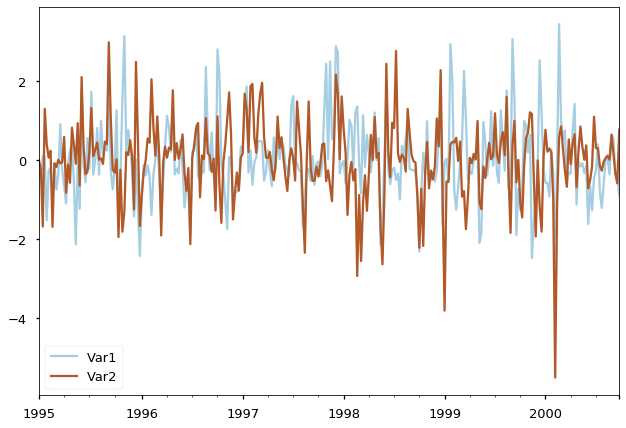

In [14]:
data.plot(colormap=mpl.cm.get_cmap('Paired'))

In [15]:
time_dim = data.shape[0]
regressor_dim = data.shape[1] + int(include_mean)
regressand_dim = data.shape[1]

In [16]:
stick_scale = 5
# mean and standard deviation
beta_mu = 0 * np.eye(regressor_dim,regressand_dim, k=-1)
beta_sigma = .25 * np.eye(regressor_dim, regressor_dim) 
beta_df = 5
comp_cov_mu1 = 3
comp_cov_mu2 = 3
# comp_std_mean = .25
# comp_cov_mean = comp_std_mean**2 * np.ones(regressand_dim)


In [17]:
beta = pd.DataFrame(beta_mu)
beta.columns=list(data.columns)
beta.index = ['Intercept'] + list(data.columns)

In [18]:
comp_cov_mean =  .5 * ( 1 - np.diag(beta.values, k=-1)) + .005

In [19]:
comp_cov_mean

array([0.505, 0.505])

In [20]:
prior = {
    'coeff': {'mean':beta.values, 'cov': beta_sigma, 'hierarchical': True, 'nu': beta_df},
    'cov':  {'scale': comp_cov_mean, 'mu1': comp_cov_mu1, 'mu2': comp_cov_mu2, 'hierarchical': True},
    'expected_cluster_dim': stick_scale,
}

In [21]:
if include_mean:
    regressor =  pd.DataFrame(add_dummy_feature(data.iloc[:-1]), index=data.index[:-1],
                             columns=['Intercept'] + list(data.columns))
else:
    regressor = data.iloc[:-1]

regressand = data.iloc[1:]

In [22]:
filename = f'../results/varmixture_cdpm{mode}.hdf'

In [23]:
return_dict = cdpm.estimate_cdpm(regressor=regressor,regressand=regressand, num_draws=num_draws, 
                                 progress_bar=tqdm_notebook, prior=prior,filename=filename,
                                 data=data, clusters=5)

In [26]:
var_filename = f'../results/varmixture_VAR{mode}.hdf'

In [27]:
return_var_dict = cdpm.estimate_var(beta_mu=beta_mu, comp_cov=comp_cov_mean * np.eye(regressand_dim),
                                    regressor=regressor, regressand=regressand, num_draws=num_draws, 
                                    progress_bar=tqdm_notebook, prior=prior,filename=var_filename, data=data)